# Goal

* If the DNA species distribution is truely Gaussian in a buoyant density gradient, then what sigma would be needed to reproduce the detection of all taxa > 0.1% in abundance throughout the entire gradient
* If 1e10 16S rRNA copies in community, then 0.1% abundant taxon = 1e7
  * If detection limit = 1 molecule, then probability density of normal distribution across the entire gradient that we sequence must be >= 1e-7 
    * ie., at least 1 of the 1e7 16S rRNA DNA molecules in every gradient fraction

## Method

* assess PDF across gradient for different levels of sigma

# Setting parameters

In [1]:
%load_ext rpy2.ipython

In [2]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/default_run/'

In [38]:
%%R

sigmas = seq(1, 50, 1)
means = seq(25, 100, 1)    # mean GC content of 30 to 70%

## max 13C shift
max_13C_shift_in_BD = 0.036
## min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
## max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD

In [49]:
%%R
max_BD

[1] 1.7744


# Init

In [39]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(gridExtra)

In [40]:
import numpy as np         
import pandas as pd                                                             
import scipy.stats as stats
import dill

In [41]:
%%R

GC2BD = function(GC) GC / 100.0 * 0.098 + 1.66     
GC2BD(50) %>% print
BD2GC = function(BD) (BD - 1.66) / 0.098 * 100
BD2GC(1.709) %>% print    

[1] 1.709
[1] 50


# GC min-max

In [42]:
%%R
min_GC = BD2GC(min_BD)
max_GC = BD2GC(max_BD)
cat('Min-max GC:', min_GC, max_GC, '\n')

Min-max GC: 13.5 116.7347 


# How big must sigma be to detect throughout the gradient?

In [43]:
%%R 

# where is density > X
detect_thresh = function(mean, sd, min_GC=13, max_GC=117){
    GCs = min_GC:max_GC
    dens = dnorm(GCs, mean=mean, sd=sd)
    all(dens > 1e-9)
    }

df = expand.grid(means, sigmas)
colnames(df) = c('mean', 'sigma')
df$detect = mapply(detect_thresh, mean=df$mean, sd=df$sigma)
df %>% head(n=4)

  mean sigma detect
1   25     1  FALSE
2   26     1  FALSE
3   27     1  FALSE
4   28     1  FALSE


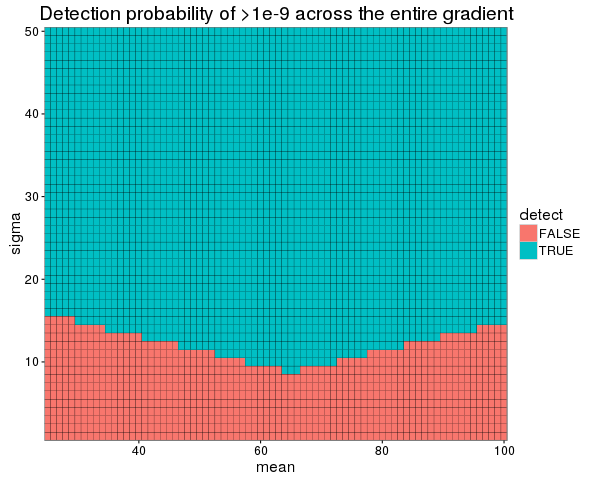

In [46]:
%%R -w 600
# plotting
ggplot(df, aes(mean, sigma, fill=detect)) +
    geom_tile(color='black') +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_continuous(expand=c(0,0)) +
    labs(title='Detection probability of >1e-9 across the entire gradient') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* sigma must be >= 18 to have taxon detected in all gradients
  * assuming mean GC of taxon fragments is 30%
* How small would the fragments need to be to explain this just from diffusion (Clay et al., 2003)?

# How small of fragments would be needed to get the observed detection threshold?

## sigma distribution of fragment GC for the reference dataset genomes

In [124]:
# loading fragments
F = os.path.join(workDir, '1', 'fragsParsed.pkl')
with open(F, 'rb') as inFH:
    frags = dill.load(inFH)

In [166]:
stds = []
for x in frags:
    otu = x[0]
    for scaf,arr in x[1].items():
        arr = np.array(arr)
        sd = np.std(arr[:,2])   # fragment GC
        stds.append([otu, scaf, sd])
stds = np.array(stds)

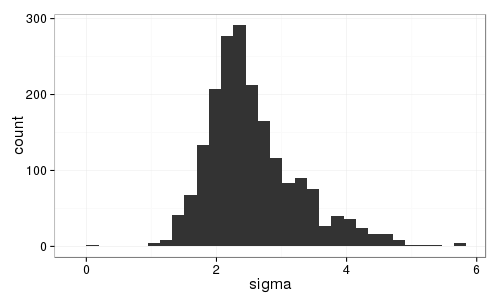

In [116]:
%%R -i stds -w 500 -h 300

stds = stds %>% as.data.frame
colnames(stds) = c('taxon', 'scaffold', 'sigma')
stds = stds %>%
    mutate(sigma = sigma %>% as.character %>% as.numeric)

ggplot(stds, aes(sigma)) +
    geom_histogram() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [130]:
%%R
# using 10% quantile 
## a relatively small, but not totally outlier of a sigma 
## this will require a lot of diffusion
q10 = quantile(stds$sigma, probs=c(0.1)) %>% as.vector
q10

[1] 1.819238


In [156]:
%%R
# function for sigma diffusion (Clay et al., 2003)
sigma_dif = function(L){
    sqrt(44.5 / L)
}

# function for calculating total sigma (fragment buoyant density) based on mean fragment length
total_sigma = function(L, sigma_start){
    # L = fragment length (kb)
    # start_sigma = genome sigma prior to diffusion
    sigma_D = sigma_dif(L)
    sqrt(sigma_D**2 + sigma_start**2)
}

frag_lens = seq(0.1, 20, 0.1)

total_sd = sapply(frag_lens, total_sigma, sigma_start=q10)
df = data.frame('length__kb' = frag_lens, 'sigma' = total_sd)
df %>% head

  length__kb     sigma
1        0.1 21.173323
2        0.2 15.026963
3        0.3 12.314340
4        0.4 10.703253
5        0.5  9.607790
6        0.6  8.802062


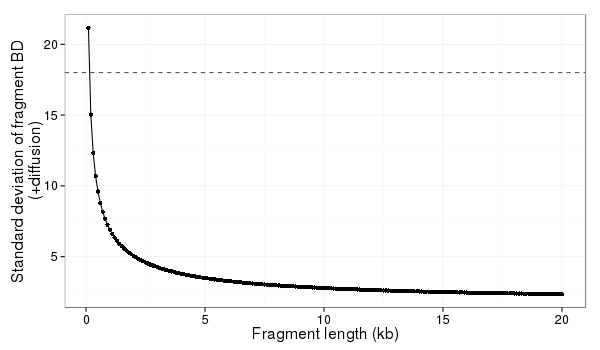

In [157]:
%%R -w 600 -h 350
# plotting
ggplot(df, aes(length__kb, sigma)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept=18, linetype='dashed', alpha=0.7) +
    labs(x='Fragment length (kb)', y='Standard deviation of fragment BD\n(+diffusion)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Percent of taxa that would be detected in all fraction depending on the fragment BD stdev with accounting for diffusion

In [158]:
%%R
sigma_thresh = 18

frag_lens = seq(0.1, 20, 0.1)
df = expand.grid(stds$sigma, frag_lens) 
colnames(df) = c('sigma', 'length__kb')

df$total_sd = mapply(total_sigma, df$length__kb, df$sigma)
df$detect = ifelse(df$total_sd >= sigma_thresh, 1, 0) 

df = df %>%
    group_by(length__kb) %>%
    summarize(n = n(),
              detected = sum(detect),
              detect_perc = detected / n * 100)
df %>% head(n=3)

Source: local data frame [3 x 4]

  length__kb     n detected detect_perc
       (dbl) (int)    (dbl)       (dbl)
1        0.1  1954     1954         100
2        0.2  1954        0           0
3        0.3  1954        0           0


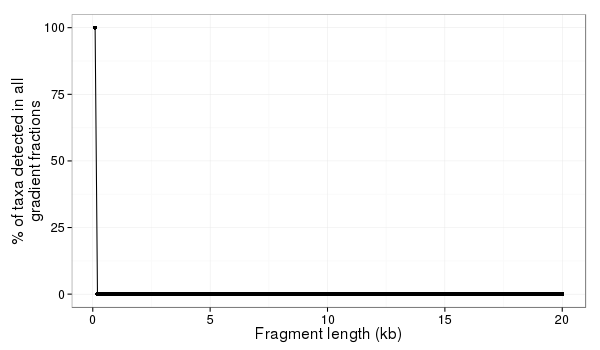

In [167]:
%%R -w 600 -h 350
# plotting
ggplot(df, aes(length__kb, detect_perc)) +
    geom_point() +
    geom_line() +
    labs(x='Fragment length (kb)', y='% of taxa detected in all\ngradient fractions') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* This analysis indicates that using a gaussian distribution to model the distribution of DNA fragments in a CsCl gradient does not fit the emperical observation that taxa of >0.1% abundance are detected in all gradient fractions.
* Even when including diffusion (Clay et al., 2003), the mean fragment size would have to be <= 100 bp to have taxa detected in all gradient fractions.

#### Future work

* Need to test with out the assumption that genome fragment are homogenous in GC content.
* Method:
  * SIPSim simulations with differing fragment length distrubutions (differing diffusion):
     * 100 - 1000 bp
     * 1000 - 2000 bp
     * 4000 - 5000 bp
  * Assessing which taxa are present in all 'sequenced' gradient fractions
     * Determine approx abundance threshold for taxa present in fractions
       * Is it near 0.1%?